In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, PillowWriter
from typing import List
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.rcParams['animation.embed_limit'] = 2**128

np.random.seed(0)
def sample_elliptical_grains(n: int) -> np.ndarray:

    dimensions = np.random.uniform(0.15,0.25,size = (n,2))
    angle = np.random.normal(0, 5,(n,1))
    X = np.random.uniform(0, 1, (n,2))
    return np.concatenate([X, angle,dimensions], axis=1)

def sample_circular_grains(n: int, r: float | np.ndarray) -> np.ndarray:
    X = np.random.uniform(0, 1, (n,2))
    radius = np.ones([n,1])*r

    return np.concatenate([X, radius], axis=1)

class CircularGrainGrower:

    def __init__(self,grains : List[patches.Circle]):
        self._grains = grains
        self._nucleated = False

    @property
    def nucleated(self):
        return self._nucleated

    def grow_by(self,v: float):
        for grain in self._grains:
            grain.set_radius(grain.radius + v)
        
        return self._grains
    
    def initialize(self,axis):
        self._nucleated = True
        for grain in self._grains:
            axis.add_patch(grain)
        return self._grains
    

    
# Step 1: Setup the environment
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Step 2: Initialize grains
initial_grains = sample_elliptical_grains(125)
sizes = np.linalg.norm(initial_grains[:,3:5],axis = 1)
scales = (sizes - sizes.min())/(sizes.max() -sizes.min())

scales = scales*0.55 + 0.33
alphas = 1 - sizes 
colors = plt.get_cmap('Greys')(scales)
for i,(x, y, angle, width, height) in enumerate(initial_grains):
    ellipse = patches.Ellipse((x, y), width, height, angle = angle, color= colors[i], alpha=alphas[i])
    ax.add_patch(ellipse)

# Step 3: Define nucleation
new_grains = sample_circular_grains(100,0.001)
growth_grains = []
for (x,y,r) in new_grains:
    circle = patches.Circle((x, y), r, color='firebrick', alpha=1.0)
    growth_grains.append(circle)

grower = CircularGrainGrower(growth_grains)
ax.set_facecolor(colors[0])
ax.set_aspect('equal')
ax.axis('off')
fig.tight_layout(pad = 0.1)
# Step 4: Animate growth
def animate(frame):
    if not grower.nucleated:
        return grower.initialize(ax)
    else:
        return grower.grow_by(0.0025)


ani = FuncAnimation(fig, animate, frames=100, interval=50,blit = True)
ani.save("grain_growth.gif", dpi=500, writer=PillowWriter(fps=10))
plt.close()


### Plot Harness & Recrystillization

percentage reduction in hardness: 18


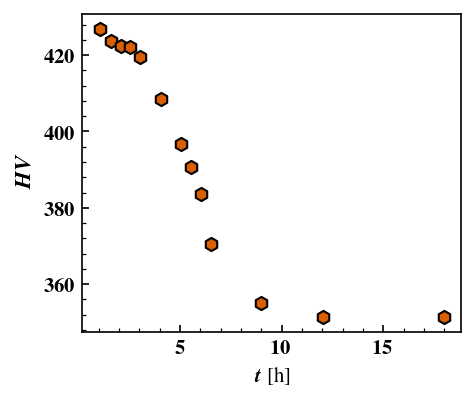

In [6]:
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def default_axis(figsize = (6,4.5), 
               xlabel: str = None,
               ylabel: str = None,
               labelsize: int = 10,
               fontsize: int = 11,
               ax: plt.Axes = None,
               n_minor_ticks: int = 5):

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    
    ax.set_xlabel(xlabel,fontsize = 10)
    ax.set_ylabel(ylabel,fontsize  = fontsize)
    ax.tick_params('both',labelsize = labelsize,direction = 'in',which = 'both')

    ax.xaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    ax.yaxis.set_minor_locator(AutoMinorLocator(n_minor_ticks))
    
    return fig,ax

#df = pd.read_csv('rf_data/alfonso_data/highly_rolled.csv',index_col = 0)

#df = df.loc[df['temperature'] == 1250]
df = pd.read_csv('rf_data/alfonso_data/highly_rolled/hv_1250C.csv')
df.columns = ['time','X']
fig,ax = default_axis(figsize = (3,2.5),
                      xlabel = r'$t$ [h]',
                      ylabel = r'$HV$')

#ax.errorbar(df['time'],df['X'].to_numpy(),yerr = df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
ax.scatter(df['time'],df['X'],facecolor  = plt.get_cmap('Dark2')(0.2),edgecolor = 'k',
           lw = 1.0,s = 40,marker = 'h',zorder = 1000)

reduction = (df['X'].max() - df['X'].min())/df['X'].max()
print(f'percentage reduction in hardness: {round(reduction*100)}')

fig.tight_layout(pad = 0.1)
fig.savefig('images/rolled_data_example_hardness_1250C.svg')

### Stress strain plot

0.002656
0.0032


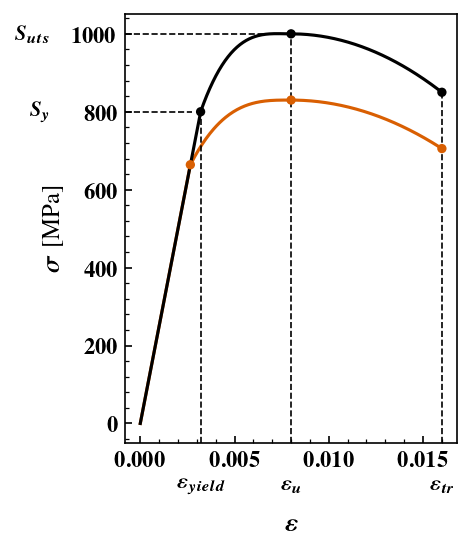

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dataclasses import dataclass
# Generate sample data for stress-strain curve
import copy

class StressStrainCurve: 

    def __init__(self ,E: float,
                        S_y: float, 
                        e_uts: float,
                        e_tr: float,
                        S_uts: float,
                        S_tr: float,
                        fac = 0.55):
        
    
        self.E = E
        self.e_uts = e_uts
        self.e_tr = e_tr
        self.S_tr = S_tr
        self.S_uts = S_uts
        self.S_y = S_y

        self.e_yield = S_y / E # Yield strain
        print(self.e_yield)
        A = np.array([[1,e_yield,e_yield**2,e_yield**3],
              [1,e_uts,e_uts**2,e_uts**3],
              [0,1,2*e_yield,3*e_yield**2],
              [0,1,2*e_uts,3*e_uts**2]])
        self.a_sh = np.linalg.solve(A,[S_y,S_uts,E*fac,0])

        A = np.array([[1,e_uts,e_uts**2],
                        [1,e_tr,e_tr**2],
                        [0,1,2*e_uts]])
        self.a_rup= np.linalg.solve(A,[S_uts,S_tr,0])   
    
    def linear_elastic(self,strain: np.ndarray) -> np.ndarray:
        return self.E*strain
    
    def strain_hardening(self,strain: np.ndarray) -> np.ndarray:
        return self.a_sh.dot(np.array([np.ones_like(strain),strain,strain**2,strain**3]))
    
    def rupture(self,strain: np.ndarray) -> np.ndarray:
        return self.a_rup.dot(np.array([np.ones_like(strain),strain,strain**2]))
    
    def __call__(self,strain: np.ndarray) -> np.ndarray:
        return np.piecewise(strain, 
                      [strain < self.e_yield, (strain >= self.e_yield) & (strain < self.e_uts), strain >=self.e_uts],
                      [lambda x: self.linear_elastic(x),
                       lambda x: self.strain_hardening(x), 
                       lambda x: self.rupture(x)])
    
E = 250*1e3 # Young's modulus in GPa
S_y = 800 # Yield strength in MPa



S_uts = 1000 #Ultimate tensile strength in MPa
S_tr = 0.25*(S_uts  - S_y) + S_y
        
# Create the plot
fig, ax = plt.subplots(figsize=(3, 3.5))

for mult,color in zip([0.83,1],[plt.get_cmap('Dark2')(0.2),'k']):
    e_yield = mult*S_y / E
    e_uts = 2.5*e_yield/mult
    e_tr = 2*e_uts
    strain = np.linspace(0, e_tr, 400)
    stress = StressStrainCurve(E,S_y*mult,e_uts,e_tr,S_uts*mult,S_tr*mult,fac= 0.55*mult**2)(strain)

    # Define key points
    yield_point = (e_yield, S_y*mult)
    ultimate_point = (e_uts, S_uts*mult)  # Updated ultimate point
    rupture_point = (e_tr,S_tr*mult)


    ax.plot(strain, stress,lw = 1.5,color = color)
    ax.scatter(*yield_point, color=color, zorder=5,s = 20,edgecolor  ='none')
    ax.scatter(*ultimate_point, color= color, zorder=5,s = 20,edgecolor  ='none')
    ax.scatter(*rupture_point, color=color, zorder=5,s = 20,edgecolor  ='none')


arrow = dict(facecolor='black', shrink=0.1, width = 1,headwidth = 5,headlength = 10)

# Annotate key points with smaller arrows
"""
ax.annotate('Yield', xy=yield_point, xytext=(yield_point[0] + 0.005, yield_point[1] - 10),
            arrowprops=arrow,fontsize = 9)  # Smaller arrow
ax.annotate('Ultimate', xy=ultimate_point, xytext=(ultimate_point[0] + 0.005, ultimate_point[1] - 10),
            arrowprops=arrow,fontsize = 9)  # Smaller arrow
ax.annotate('Rupture', xy=rupture_point, xytext=(rupture_point[0] - 0.005, rupture_point[1] + 10),
            arrowprops=arrow,fontsize = 9)  # Smaller arrow
"""

ymin1,ymax1 = ax.get_ylim()
xmin1,xmax1 = ax.get_xlim()
scale = lambda x: (x - ymin1)/(ymax1 - ymin1)

# Add horizontal dotted lines
ax.axhline(y=yield_point[1], xmax=yield_point[0] / e_tr, color='k', linestyle='--', linewidth=0.8)
ax.axhline(y=ultimate_point[1], xmax=ultimate_point[0] / e_tr, color='k', linestyle='--', linewidth=0.8)

# Add vertical dotted lines
ax.axvline(x=yield_point[0],ymax = scale(yield_point[1]), color='k', linestyle='--', linewidth=0.8)
ax.axvline(x=ultimate_point[0],ymax = scale(ultimate_point[1]),color='k', linestyle='--', linewidth=0.8)
ax.axvline(x=rupture_point[0], ymax = scale(rupture_point[1]),color='k', linestyle='--', linewidth=0.8)

# Label points on the y-axis
ax.text(-e_tr*0.3, yield_point[1], r'$S_y$', ha='right', va='center', fontsize=10)
ax.text(-0.3*e_tr, ultimate_point[1], r'$S_{uts}$', ha='right', va='center', fontsize=10)


# Set labels and title
ax.set_xlabel(r'$\varepsilon$',fontsize = 12,labelpad = 20)
ax.set_ylabel(r'$\sigma$ [MPa]',fontsize = 12)
ax.tick_params('both',labelsize = 11,direction = 'in',which = 'both')

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.text(yield_point[0], ymin1 - 0.075 * (ymax1 - ymin1), r'$\varepsilon_{yield}$', ha='center', va='top', fontsize=10)
ax.text(ultimate_point[0], ymin1 - 0.075 * (ymax1 - ymin1), r'$\varepsilon_{u}$', ha='center', va='top', fontsize=10)
ax.text(rupture_point[0], ymin1 - 0.075 * (ymax1 - ymin1), r'$\varepsilon_{tr}$', ha='center', va='top', fontsize=10)

# Display the plot
fig.tight_layout(pad = 0.1)
plt.show()
fig.savefig('images/stress_strain_curve_ductile_reduced.svg')

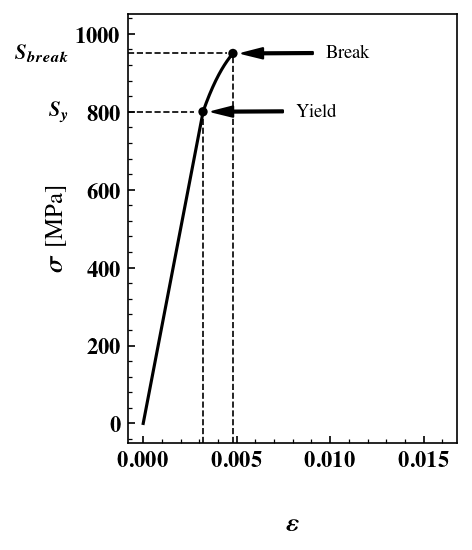

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Define key points
e_brittle = 1.5*e_yield
yield_point = (e_yield, S_y)
S_brittle = a_sh.dot(np.array([1,e_brittle,e_brittle**2,e_brittle**3]))
break_point = (e_brittle, S_brittle)

strain = np.linspace(0, e_brittle, 200)
stress = np.piecewise(strain, 
                      [strain < e_yield, (strain >= e_yield) & (strain <= e_brittle)],
                      [lambda x: E*x,
                       lambda x: a_sh.dot(np.array([np.ones_like(x),x,x**2,x**3]))]) 

# Create the plot
fig, ax = plt.subplots(figsize=(3, 3.5))
ax.plot(strain, stress, label='Stress-Strain Curve', lw=1.5, color='k')
ax.scatter(*yield_point, color='k', zorder=5, s=20, edgecolor='none')
ax.scatter(*break_point, color='k', zorder=5, s=20, edgecolor='none')

arrow = dict(facecolor='black', shrink=0.1, width=1, headwidth=5, headlength=10)

# Annotate key points with smaller arrows
ax.annotate('Yield', xy=yield_point, xytext=(yield_point[0] + 0.005, yield_point[1] - 10),
            arrowprops=arrow, fontsize=9)  # Smaller arrow
ax.annotate('Break', xy=break_point, xytext=(break_point[0] + 0.005, break_point[1] - 10),
            arrowprops=arrow, fontsize=9)  # Smaller arrow

ax.set_xlim([xmin1,xmax1])
ax.set_ylim([ymin1,ymax1])

ymin, ymax = ax.get_ylim()
scale = lambda x: (x - ymin) / (ymax - ymin)

# Add horizontal dotted lines
ax.axhline(y=yield_point[1], xmax=yield_point[0] / e_tr, color='k', linestyle='--', linewidth=0.8)
ax.axhline(y=break_point[1], xmax=break_point[0] / e_tr, color='k', linestyle='--', linewidth=0.8)

# Add vertical dotted lines
ax.axvline(x=yield_point[0], ymax=scale(yield_point[1]), color='k', linestyle='--', linewidth=0.8)
ax.axvline(x=break_point[0], ymax=scale(break_point[1]), color='k', linestyle='--', linewidth=0.8)

# Label points on the y-axis
ax.text(-e_tr * 0.25, yield_point[1], r'$S_y$', ha='right', va='center', fontsize=10)
ax.text(-e_tr * 0.25, break_point[1], r'$S_{break}$', ha='right', va='center', fontsize=10)
# Set labels and title
ax.set_xlabel(r'$\varepsilon$', fontsize=12, labelpad=20)
ax.set_ylabel(r'$\sigma$ [MPa]', fontsize=12)
ax.tick_params('both', labelsize=11, direction='in', which='both')

ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
# Label points on the x-axis
# Display the plot
fig.tight_layout(pad=0.1)
plt.show()
fig.savefig('images/stress_strain_curve_brittle.svg')

### Control System Response Time

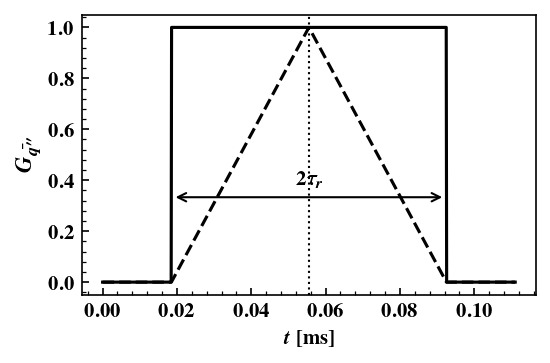

In [19]:
fig,ax = default_axis(figsize = (3.5,2.25),
                      xlabel = r'$t$ \textbf{[ms]}',
                      ylabel = r'$G_{\bar{q^{\prime \prime}}}$')

tau_r = 37e-3
t = np.linspace(0,3*tau_r,1000)
g_top_hat = np.piecewise(t,
                         [t < tau_r*0.5, 
                          np.all(np.array([t >= 0.5*tau_r, t < 2.5*tau_r]).T,axis = 1),
                          t >= 2.5*tau_r],
                          [lambda x: 0,
                           lambda x: 1, 
                           lambda x: 0])
g_triangle = np.piecewise(t,
                         [t < tau_r*0.5, 
                          np.all(np.array([t >= 0.5*tau_r, t < 1.5*tau_r]).T,axis = 1),
                          np.all(np.array([t >= 1.5*tau_r, t < 2.5*tau_r]).T,axis = 1),
                          t >= 2.5*tau_r],
                          [lambda x: 0,
                           lambda x: (x - 0.5*tau_r)/tau_r,
                            lambda x: 1 - (x - 1.5*tau_r)/tau_r, 
                           lambda x: 0])

arrow_y = 1/3  # 1/3 of the way up from the x-axis
ax.annotate('', xy=(0.5 * tau_r, arrow_y), xytext=(2.5 * tau_r, arrow_y),
            arrowprops=dict(arrowstyle='<->', color='black'))

# Add textbox
ax.text(1.5 * tau_r, arrow_y + 0.05, r'$2 \tau_r$', ha='center')

ax.plot(t,g_top_hat,lw = 1.5,color = 'k')
ax.plot(t,g_triangle,lw = 1.5,color = 'k',ls = '--')
ax.axvline(1.5*tau_r,ls = ':',color = 'k',lw = 1.0)
fig.tight_layout(pad = 0.1)

fig.savefig('images/strike_point_heat_flux_gain_functions.svg')